In [47]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

## define bucket in which you are trying to reach
s3 = boto3.resource('s3')
bucket_name = 'daltondencklau-data445-bucket'
bucket = s3.Bucket(bucket_name)

## define csv file to read in the bucket
file_key= 'train.csv'

## syntax to allow us to read the file
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## reading the training data file
train = pd.read_csv(file_content_stream, sep = '|')
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [48]:
## reading the test file
file_key= 'test.csv'

## syntax to allow us to read the file
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## reading the training data file
test = pd.read_csv(file_content_stream, sep = '|')
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


### Exercise 2: Feature Engineering
***

In [49]:
## feature engineering using boxcox transformation
transformed_trust_level = boxcox(train['trustLevel'])

train['trustLevel'] = transformed_trust_level[0]

transformed_trust_level = boxcox(test['trustLevel'])

test['trust_level'] = transformed_trust_level[0]

In [50]:
## grand total / totalScanTimeInSeconds
train['grandtotal_totalscantime'] = train['grandTotal'] / train['totalScanTimeInSeconds']

test['grandtotal_totalscantime'] = test['grandTotal'] / test['totalScanTimeInSeconds']

In [51]:
## scansWithoutRegistration * quantityModifications
train['scans_quantity'] = train['scansWithoutRegistration'] * train['quantityModifications']

test['scans_quantity'] = test['scansWithoutRegistration'] * test['quantityModifications']

In [52]:
## log base 10 of grandTotal
train['grandTotal_log10'] = np.log10(train['grandTotal'])

test['grandTotal_log10'] = np.log10(test['grandTotal'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [53]:
## 1 / valuePerSecond
train['1_valuePerSecond'] = 1 / train['valuePerSecond']

test['1_valuePerSecond'] = 1 / test['valuePerSecond']

In [54]:
## scannedLineItemsPerSecond ^ 2
train['scannedLineItemsPerSecond_2'] = train['scannedLineItemsPerSecond']**2

test['scannedLineItemsPerSecond_2'] = test['scannedLineItemsPerSecond']**2

In [55]:
## scannedLineItemsPerSecond * valuePerSecond
train['scannedLineItemsPerSecond_valuePerSecond'] = train['scannedLineItemsPerSecond'] * train['valuePerSecond']

test['scannedLineItemsPerSecond_valuePerSecond'] = test['scannedLineItemsPerSecond'] * test['valuePerSecond']


### Exercise 3
***

##### Random Forest Feature Importance

In [56]:
## defining input and target variables
x = train.drop(columns = 'fraud', axis = 1)
y = train['fraud']

## defining a list to store results (feature importances)
results = list()

for i in range(0,100):
    
    ## splitting the training data into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
    ## building the RF model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(x_train, y_train)
    
    ## extracting feature importances
    results.append(rf_md.feature_importances_)
    
## transforming list into dataframe
results = pd.DataFrame(results)
results.columns = x.columns

In [57]:
results = pd.DataFrame(results.apply(np.mean, axis = 0))
results = pd.DataFrame({'Feature': results.index, 'Importances': results[0].values})
results = results.sort_values(by = 'Importances', ascending = False)

In [58]:
results

,Feature,Importances
0,trustLevel,0.325173
6,scannedLineItemsPerSecond,0.102178
13,scannedLineItemsPerSecond_2,0.100491
1,totalScanTimeInSeconds,0.094188
8,lineItemVoidsPerPosition,0.071866
12,1_valuePerSecond,0.047080
9,grandtotal_totalscantime,0.045915
7,valuePerSecond,0.045799
14,scannedLineItemsPerSecond_valuePerSecond,0.036734
2,grandTotal,0.035716


In [29]:
## engineering three more based on the top three features (from above) using the strong heredity principle

In [59]:
## trustLevel * scannedLineItemsPerSecond
train['interaction_1'] = train['trustLevel'] * train['scannedLineItemsPerSecond']

test['interaction_1'] = test['trustLevel'] * test['scannedLineItemsPerSecond']

In [60]:
## scannedLineItemsPerSecond_2 * trustLevel
train['interaction_2'] = train['scannedLineItemsPerSecond_2'] * train['trustLevel']

test['interaction_2'] = test['scannedLineItemsPerSecond_2'] * test['trustLevel']

In [61]:
## scannedLineItemsPerSecond_2 * scannedLineItemsPerSecond
train['interaction_3'] = train['scannedLineItemsPerSecond_2'] * train['scannedLineItemsPerSecond']

test['interaction_3'] = test['scannedLineItemsPerSecond_2'] * test['scannedLineItemsPerSecond']


##### Decision Tree Feature Engineering

[Text(0.5769230769230769, 0.875, 'trustLevel <= 0.431\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.3076923076923077, 0.625, 'scannedLineItemsPerSecond <= 0.012\ngini = 0.396\nsamples = 261\nvalue = [190, 71]'),
 Text(0.15384615384615385, 0.375, 'scannedLineItemsPerSecond_2 <= 0.0\ngini = 0.042\nsamples = 94\nvalue = [92, 2]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.0\nsamples = 83\nvalue = [83, 0]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.298\nsamples = 11\nvalue = [9, 2]'),
 Text(0.46153846153846156, 0.375, 'totalScanTimeInSeconds <= 896.5\ngini = 0.485\nsamples = 167\nvalue = [98, 69]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.338\nsamples = 102\nvalue = [80, 22]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.4\nsamples = 65\nvalue = [18, 47]'),
 Text(0.8461538461538461, 0.625, 'trustLevel <= 1.212\ngini = 0.019\nsamples = 1242\nvalue = [1230, 12]'),
 Text(0.7692307692307693, 0.375, 'totalScanTimeInSeconds <= 1304.0\ngini = 0.085\nsamples = 270\nvalue = [

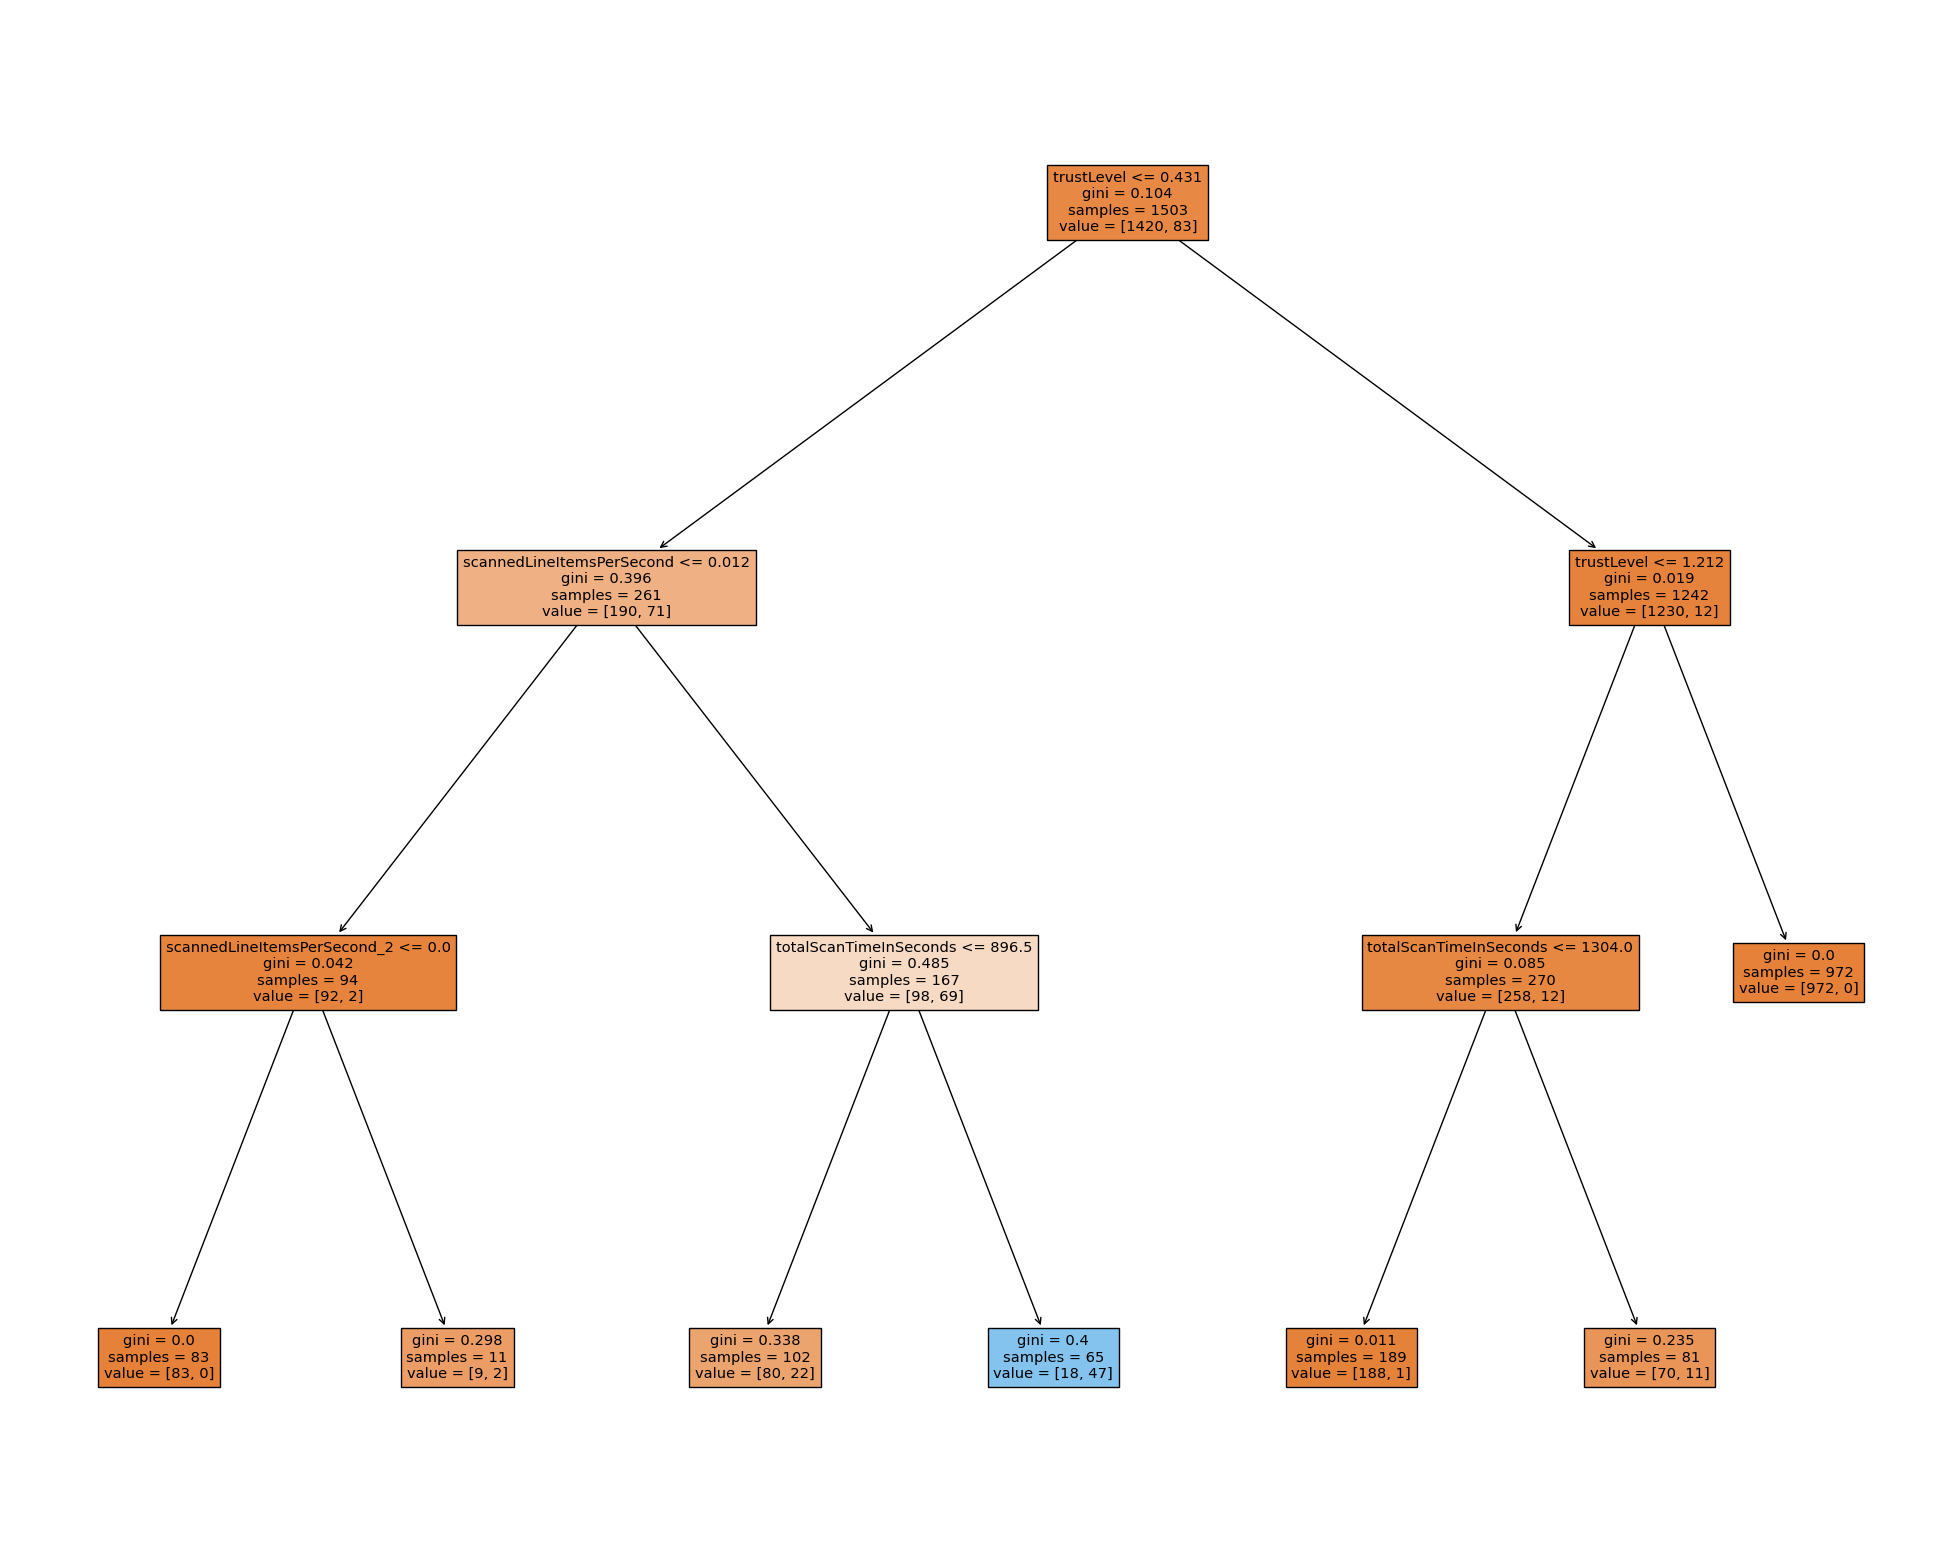

In [68]:
## defining input and target variables
x = train.drop(columns = ['fraud'], axis = 1)
y = train['fraud']

## splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

## building Decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

## plotting the decision tree
fig = plt.figure(figsize = (25, 20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5769230769230769, 0.875, 'interaction_2 <= 0.0\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.3076923076923077, 0.625, 'scannedLineItemsPerSecond <= 0.012\ngini = 0.389\nsamples = 276\nvalue = [203, 73]'),
 Text(0.15384615384615385, 0.375, 'lineItemVoids <= 10.5\ngini = 0.021\nsamples = 94\nvalue = [93, 1]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.0\nsamples = 89\nvalue = [89, 0]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.46153846153846156, 0.375, 'totalScanTimeInSeconds <= 895.0\ngini = 0.478\nsamples = 182\nvalue = [110, 72]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.332\nsamples = 114\nvalue = [90, 24]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.415\nsamples = 68\nvalue = [20, 48]'),
 Text(0.8461538461538461, 0.625, 'trustLevel <= 1.212\ngini = 0.016\nsamples = 1227\nvalue = [1217, 10]'),
 Text(0.7692307692307693, 0.375, 'totalScanTimeInSeconds <= 1298.0\ngini = 0.069\nsamples = 280\nvalue = [270, 10]'),

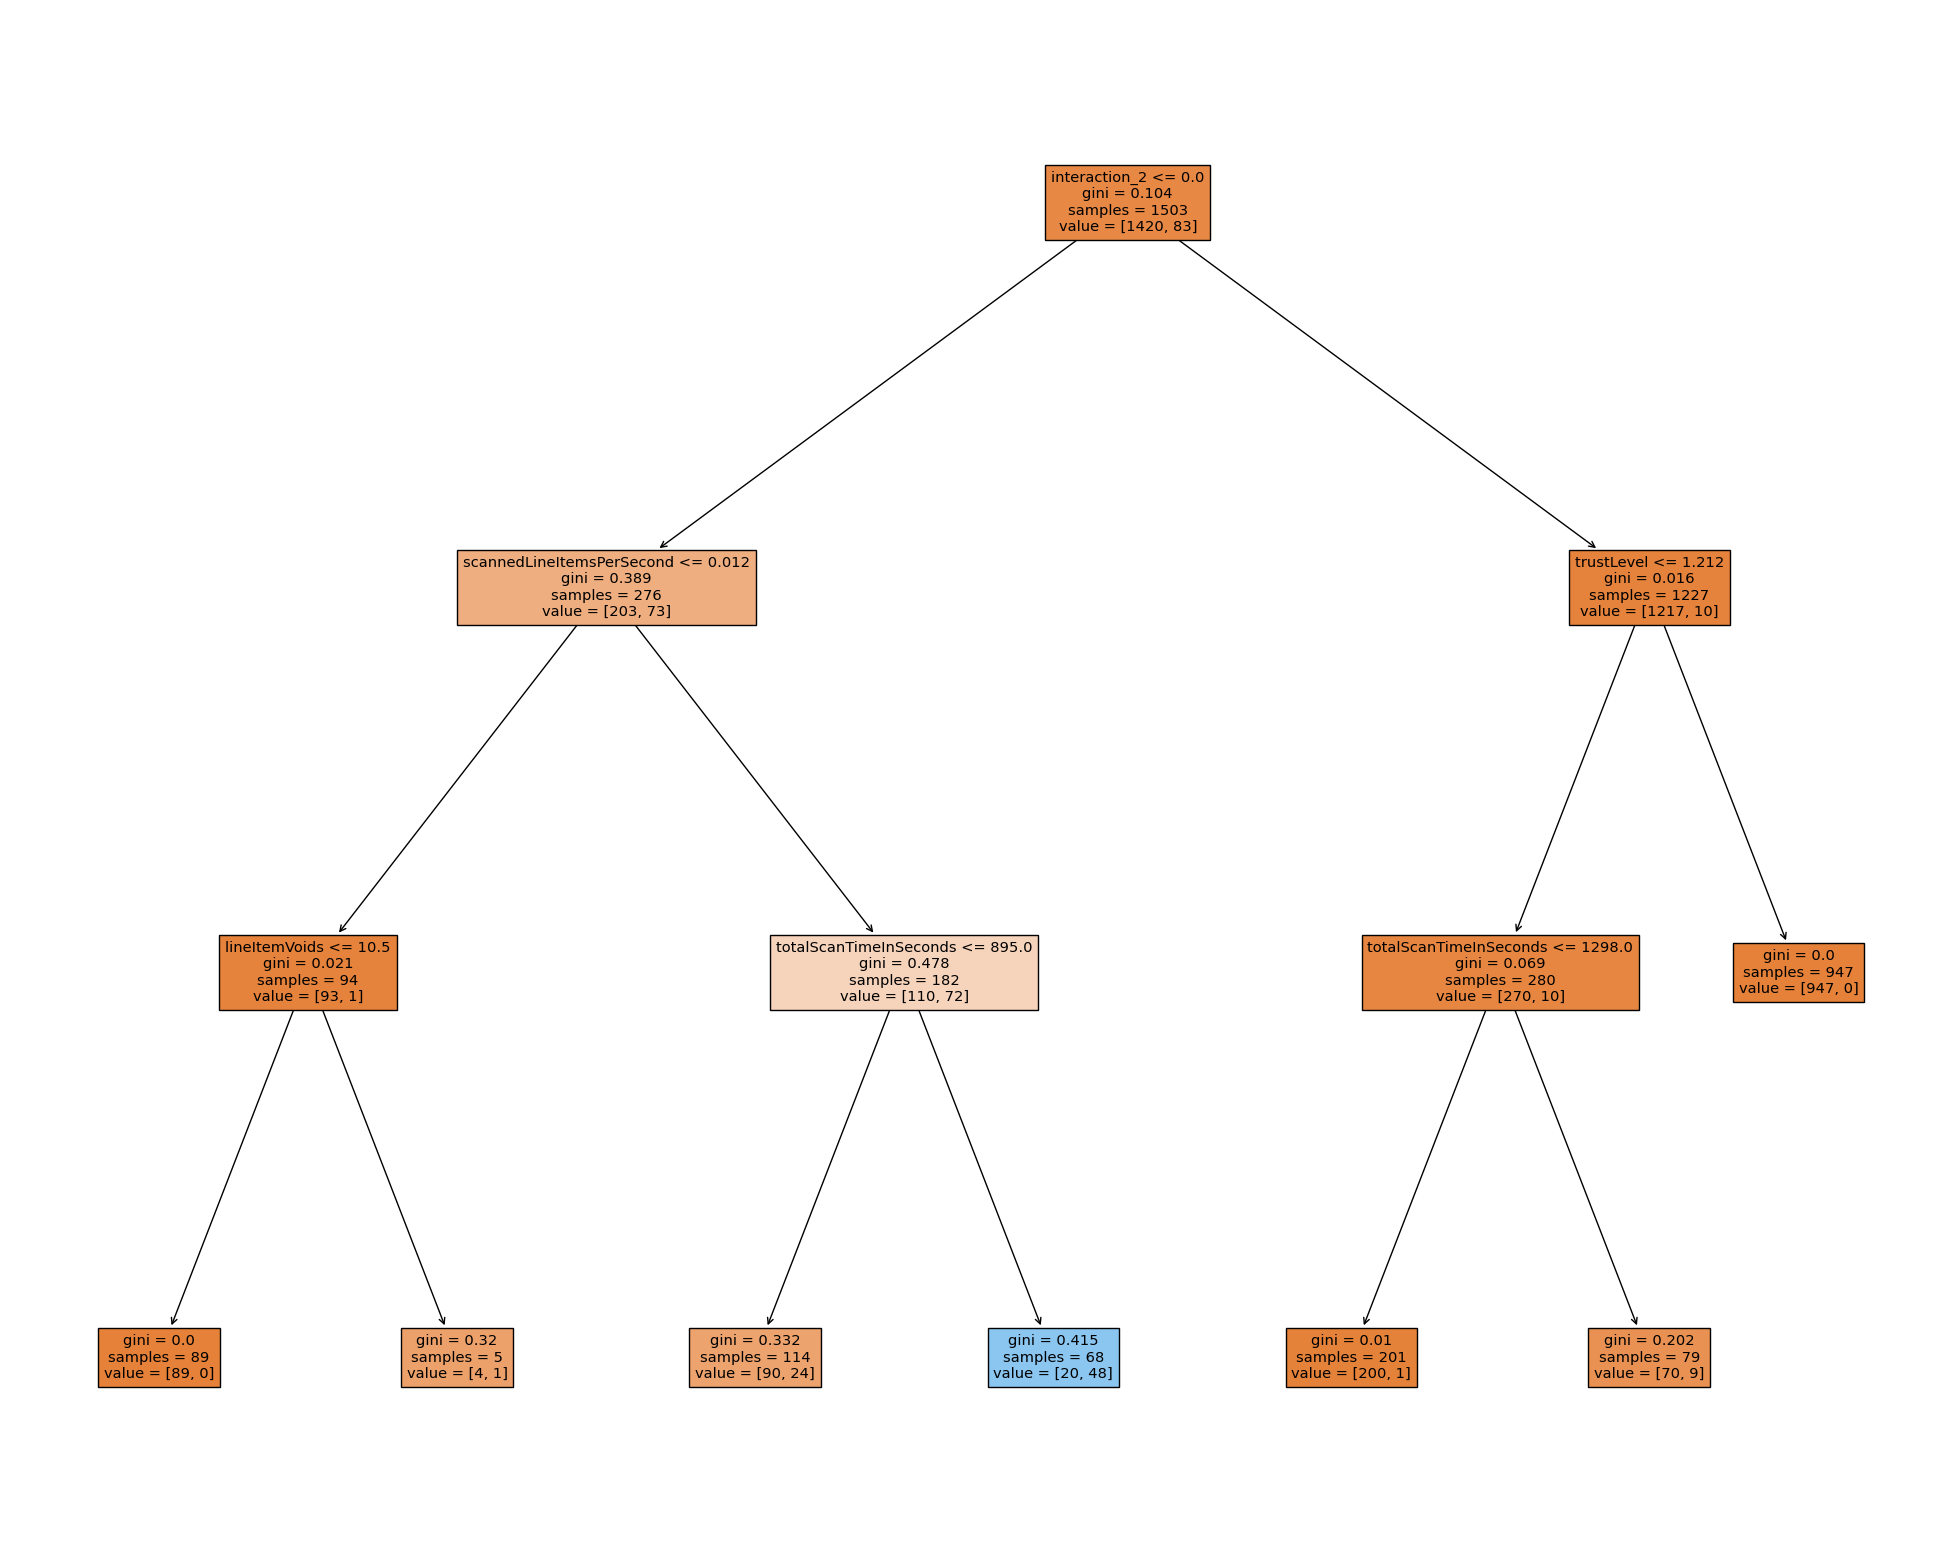

In [66]:
## defining input and target variables
x = train.drop(columns = ['fraud'], axis = 1)
y = train['fraud']

## splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

## building Decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

## plotting the decision tree
fig = plt.figure(figsize = (25, 20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5, 0.875, 'trustLevel <= 0.431\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.2, 0.625, 'scannedLineItemsPerSecond <= 0.012\ngini = 0.393\nsamples = 268\nvalue = [196, 72]'),
 Text(0.1, 0.375, 'gini = 0.0\nsamples = 90\nvalue = [90, 0]'),
 Text(0.3, 0.375, 'totalScanTimeInSeconds <= 895.0\ngini = 0.482\nsamples = 178\nvalue = [106, 72]'),
 Text(0.2, 0.125, 'gini = 0.322\nsamples = 109\nvalue = [87, 22]'),
 Text(0.4, 0.125, 'gini = 0.399\nsamples = 69\nvalue = [19, 50]'),
 Text(0.8, 0.625, 'trustLevel <= 1.212\ngini = 0.018\nsamples = 1235\nvalue = [1224, 11]'),
 Text(0.7, 0.375, 'grandTotal <= 99.445\ngini = 0.075\nsamples = 282\nvalue = [271, 11]'),
 Text(0.6, 0.125, 'gini = 0.069\nsamples = 281\nvalue = [271, 10]'),
 Text(0.8, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.9, 0.375, 'gini = 0.0\nsamples = 953\nvalue = [953, 0]')]

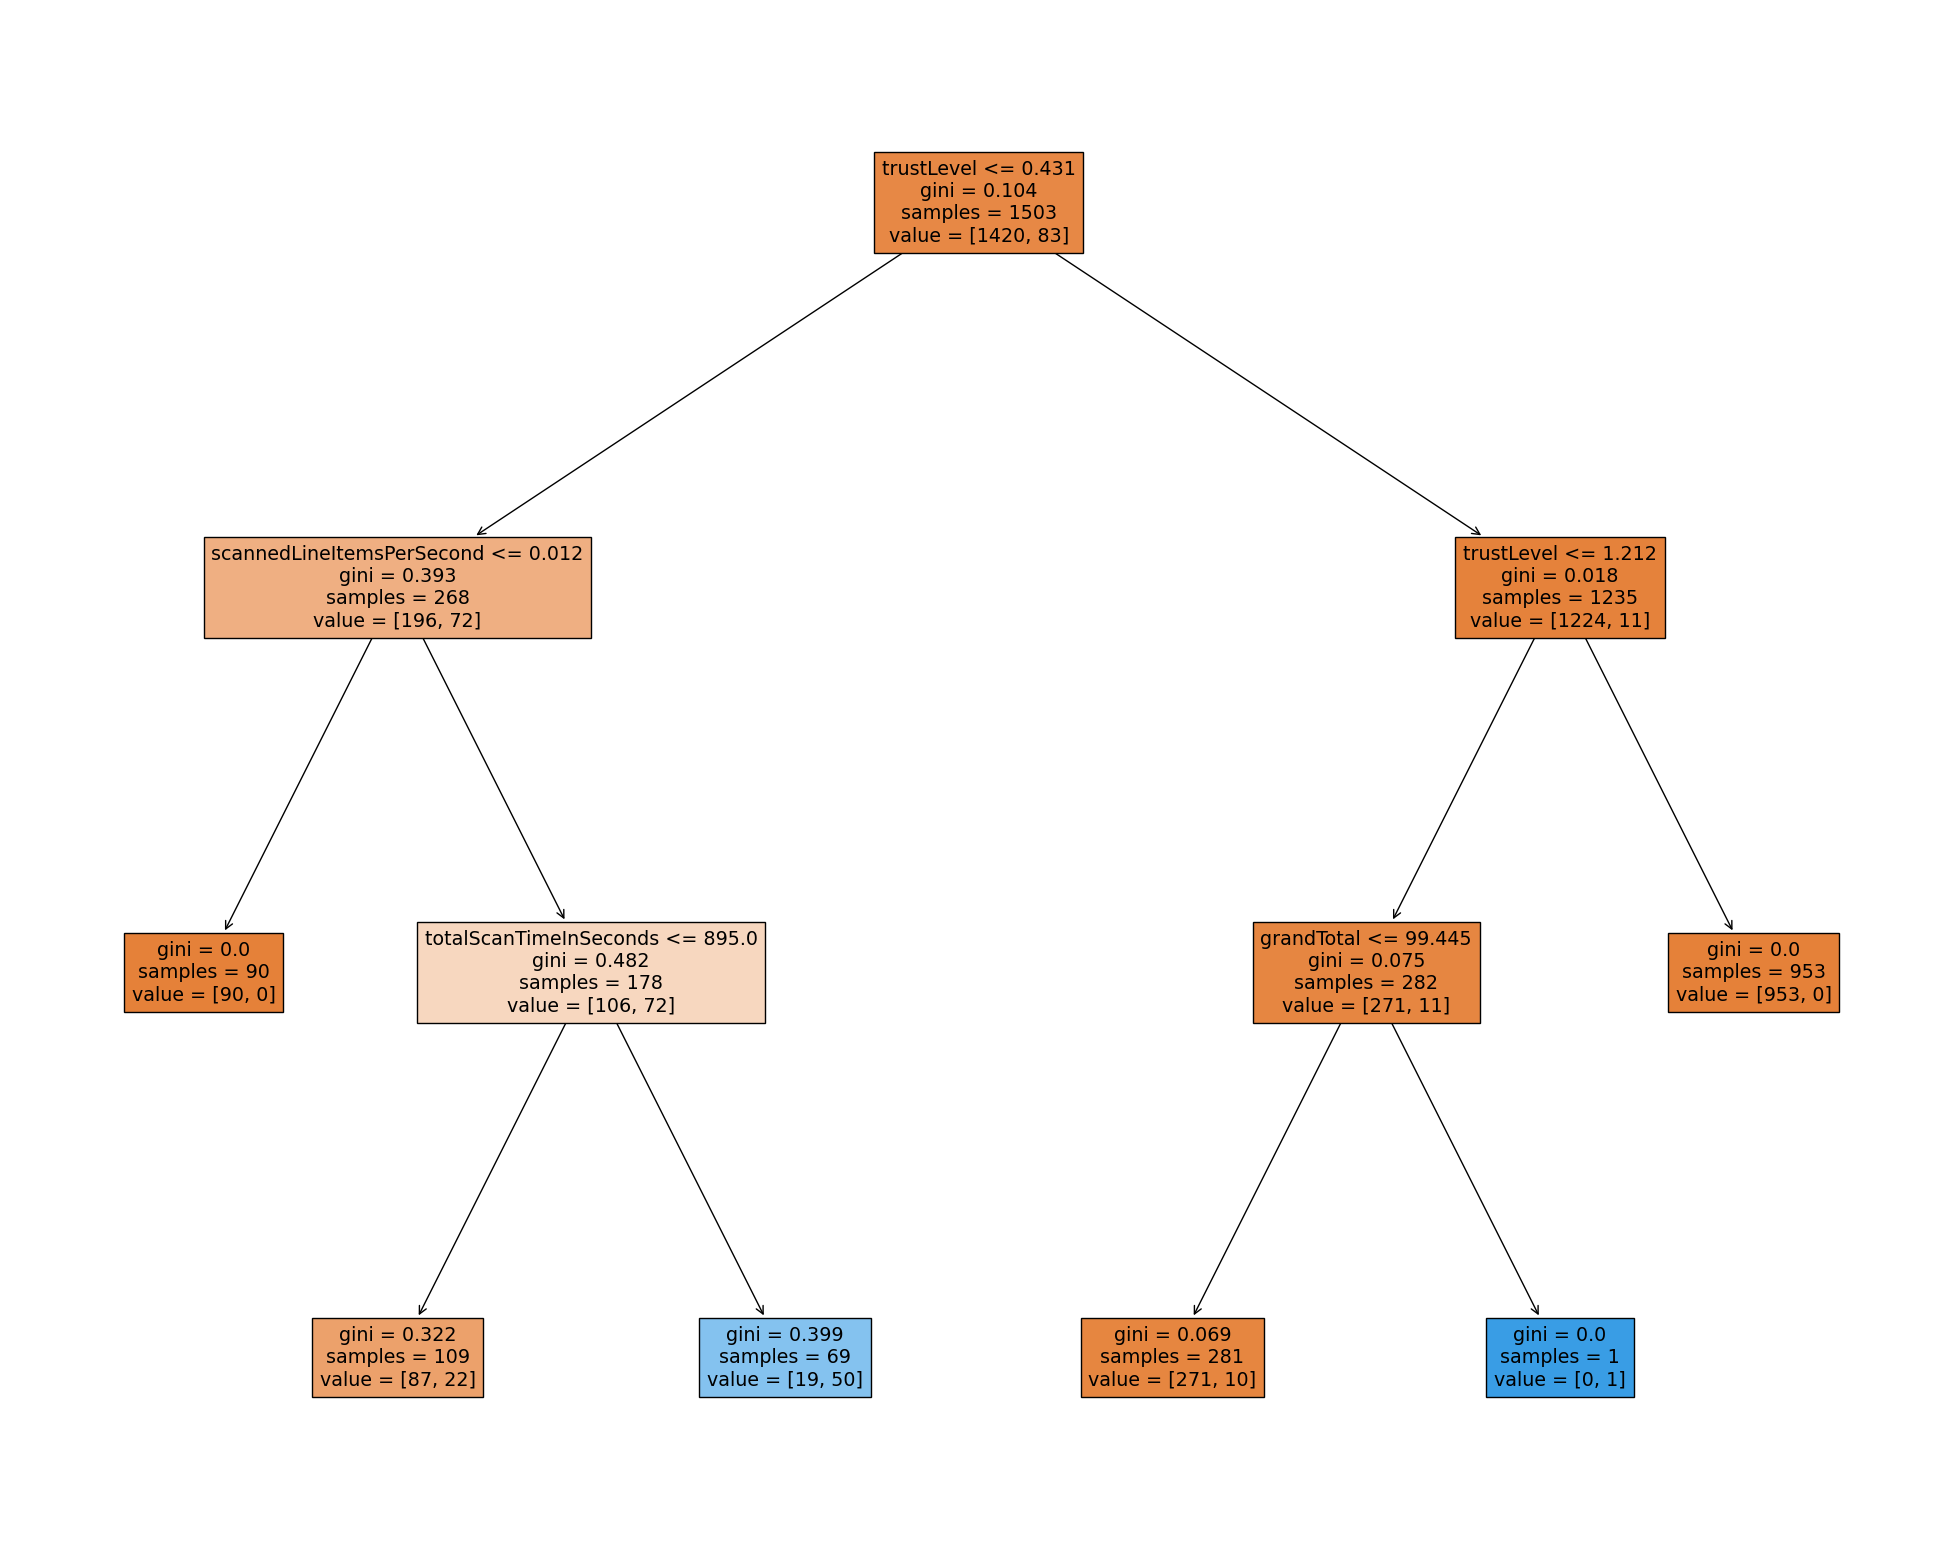

In [64]:
## defining input and target variables
x = train.drop(columns = ['fraud'], axis = 1)
y = train['fraud']

## splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

## building Decision tree
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)

## plotting the decision tree
fig = plt.figure(figsize = (25, 20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

In [69]:
## engineering feature based on the decision tree results


train['interaction_4'] = np.where(((train['trustLevel'] <= 0.431) &
                                      (train['scannedLineItemsPerSecond'] <= 0.012) &
                                      (train['totalScanTimeInSeconds'] <= 895)), 1, 0)

test['interaction_4'] = np.where(((test['trustLevel'] <= 0.431) &
                                      (test['scannedLineItemsPerSecond'] <= 0.012) &
                                      (test['totalScanTimeInSeconds'] <= 895)), 1, 0)


train['interaction_5'] = np.where(((train['trustLevel'] <= 0.431) &
                                      (train['trustLevel'] <= 1.212) &
                                      (train['totalScanTimeInSeconds'] <= 1304)), 1, 0)
test['interaction_5'] = np.where(((test['trustLevel'] <= 0.431) &
                                      (test['trustLevel'] <= 1.212) &
                                      (test['totalScanTimeInSeconds'] <= 1304)), 1, 0)